In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
from sklearn.linear_model import LinearRegression 

connectome = "connections_no_threshold.csv"
connectome_thresholded = "connections.csv"
neuropil = "neuropil_synapse_table.csv"
neurons = "neurons.csv"

root = "root_id"
pre = "pre_root_id"
post = "post_root_id"

nt = "nt_type"
neuropil = "neuropil"
syn_count = "syn_count"

NTs = ["ACH", "GLUT", "GABA", "DA", "SER", "OCT"]

In [25]:
df_neurons = pd.read_csv(neurons)
print(df_neurons.columns)

Index(['root_id', 'group', 'nt_type', 'nt_type_score', 'da_avg', 'ser_avg',
       'gaba_avg', 'glut_avg', 'ach_avg', 'oct_avg'],
      dtype='object')


In [26]:
# Find all root ids of neurons of a certain nt_type!
nt_neurons_idx = df_neurons[nt] == "DA"
nt_neurons = df_neurons[nt_neurons_idx][root]
print("DA neuron count:", np.count_nonzero(nt_neurons))

DA neuron count: 584


## Find all those neurons that are in the mushroom body

In [27]:
mushroom_body_L = "MB_ML_L"
mushroom_body_R = "MB_ML_R"

In [28]:
df_connectome = pd.read_csv(connectome_thresholded)
print(df_connectome.columns)

Index(['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type'], dtype='object')


In [36]:
MB_L = df_connectome[neuropil] == mushroom_body_L
# MB_L as all neurons that are located in the mushroom body (L)
# Only indexing -> df_connectome[MB_L][post].unique() are the neuron ids

## Get the indegree of the recipients
ACH is excitatory. GABA mainly inhibitory.

## Find synaptic count for those neurons (and compare to the rest in the mushroom body)

In [38]:
%%capture 
# suppresses output

post_neurons = df_connectome[MB_L][post].unique()
ach_synapses_per_neuron = np.zeros(post_neurons.size)
gaba_synapses_per_neuron = np.zeros(post_neurons.size)
da_synapses_per_neuron = np.zeros(post_neurons.size)
for i, post_neuron in enumerate(post_neurons):
    post_idx = df_connectome[post] == post_neuron  
    print("Neural connections:", np.count_nonzero(post_idx))
    
    ach_idx = df_connectome[post_idx][nt] == "ACH"
    ach_idx = ach_idx[ach_idx]
    #print("ACH connections:", np.count_nonzero(ach_idx))
    ach_synapses = df_connectome.loc[ach_idx.index][syn_count].sum()
    ach_synapses_per_neuron[i] = ach_synapses
    #print("ACH synapses:", ach_synapses)
    
    gaba_idx = df_connectome[post_idx][nt] == "GABA"
    gaba_idx = gaba_idx[gaba_idx]
    #print("GABA connections:", np.count_nonzero(gaba_idx))
    gaba_synapses = df_connectome.loc[gaba_idx.index][syn_count].sum()
    gaba_synapses_per_neuron[i] = gaba_synapses
    #print("GABA synapses:", gaba_synapses)
    
    da_idx = df_connectome[post_idx][nt] == "DA"
    da_idx = da_idx[da_idx]
    #print("DA connections:", np.count_nonzero(da_idx))
    da_synapses = df_connectome.loc[da_idx.index][syn_count].sum()
    da_synapses_per_neuron[i] = da_synapses
    #print("DA synapses:", da_synapses)
    #break

[0.62085423] 1.0510585819121294


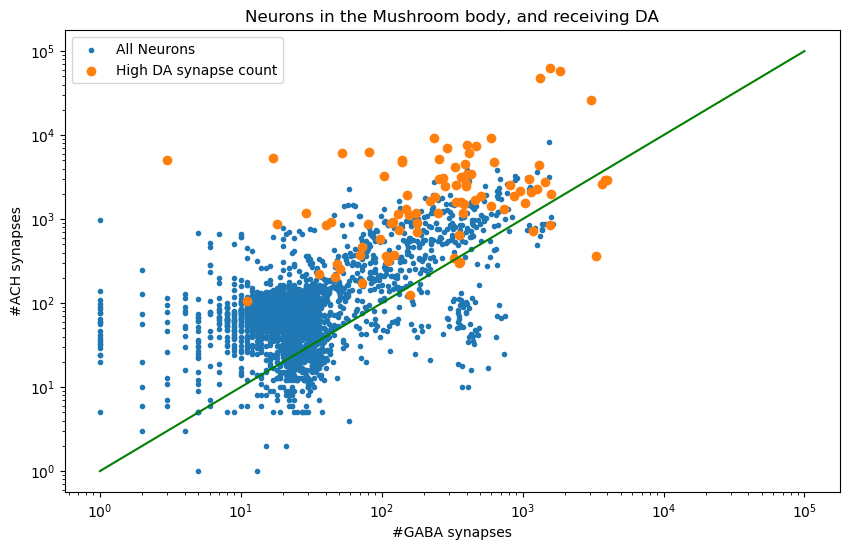

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter(gaba_synapses_per_neuron, ach_synapses_per_neuron, label="All Neurons", marker=".")
threshold = 50
plt.scatter(gaba_synapses_per_neuron[da_synapses_per_neuron > threshold], 
            ach_synapses_per_neuron[da_synapses_per_neuron > threshold], label="High DA synapse count")
plt.title("Neurons in the Mushroom body, and receiving DA")
plt.xlabel("#GABA synapses")
plt.ylabel("#ACH synapses")
plt.xscale("log")
plt.yscale("log")
plt.legend()

x = np.asarray([1, gaba_synapses_per_neuron.max()])

regression = LinearRegression()
mask = np.ones(post_neurons.size, dtype=bool)
mask[gaba_synapses_per_neuron == 0] = False
mask[ach_synapses_per_neuron == 0] = False
regression.fit(np.log10(gaba_synapses_per_neuron[mask]).reshape(-1, 1), 
               np.log10(ach_synapses_per_neuron[mask]))
print(regression.coef_, regression.intercept_)

def regress(x):
    return regression.intercept_ + regression.coef_[0] * x

log_y_pred = regression.coef_[0] * np.log10(x) + regression.intercept_
y_pred = 10**log_y_pred

#plt.plot(x, y_pred, c="red", ls="--")
#plt.plot(x, regress(x), c="k", ls="--")
plt.plot([1, 1e5], [1, 1e5], c="green")

/tmp/ipykernel_4734/1017547526.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(ach_synapses_per_neuron[da_synapses_per_neuron > threshold]/
/tmp/ipykernel_4734/1017547526.py:4: RuntimeWarning: invalid value encountered in divide
  plt.scatter(ach_synapses_per_neuron[da_synapses_per_neuron > threshold]/


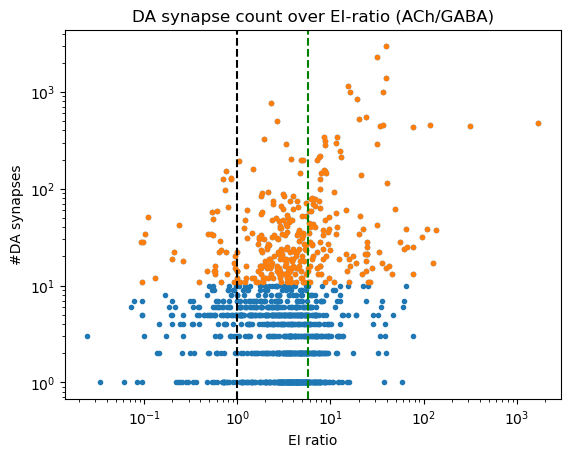

In [93]:
threshold = 10
plt.scatter(ach_synapses_per_neuron[mask]/gaba_synapses_per_neuron[mask],
            da_synapses_per_neuron[mask], marker=".")
plt.scatter(ach_synapses_per_neuron[da_synapses_per_neuron > threshold]/
            gaba_synapses_per_neuron[da_synapses_per_neuron > threshold],
            da_synapses_per_neuron[da_synapses_per_neuron > threshold], marker=".")
plt.xlabel("EI ratio")
plt.ylabel("#DA synapses")
plt.xscale("log")
plt.yscale("log")
plt.title("DA synapse count over EI-ratio (ACh/GABA)")
plt.axvline(1, c="k", ls="--")
plt.axvline((ach_synapses_per_neuron[mask]/gaba_synapses_per_neuron[mask]).mean(), ls="--", c="green")

Text(0.5, 1.0, 'DA synapse count over EI-ratio (ACh/GABA)')

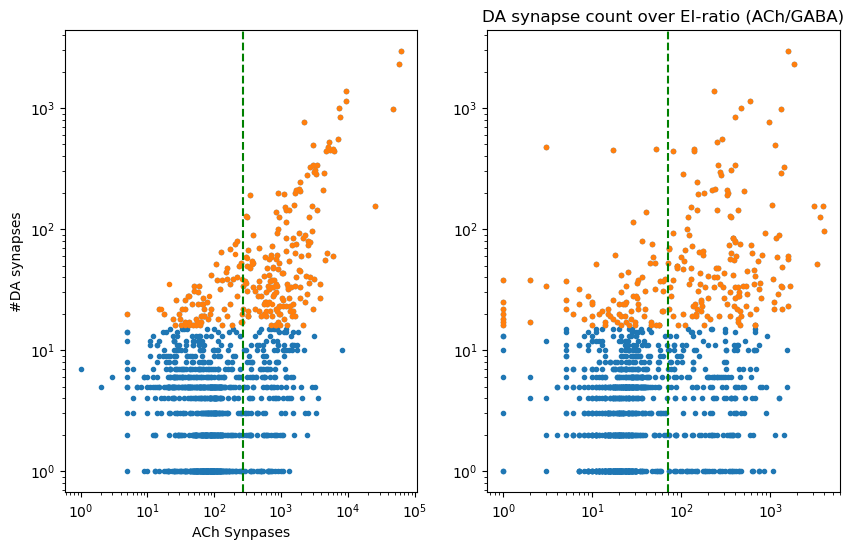

In [109]:
threshold = 15
fig, (ax_ach, ax_gaba) = plt.subplots(ncols=2, figsize=(10, 6))
ax_ach.scatter(ach_synapses_per_neuron[mask],
            da_synapses_per_neuron[mask], marker=".")
ax_ach.scatter(ach_synapses_per_neuron[da_synapses_per_neuron > threshold],
            da_synapses_per_neuron[da_synapses_per_neuron > threshold], marker=".")
ax_ach.axvline((ach_synapses_per_neuron[mask]).mean(), ls="--", c="green")
ax_ach.set_xscale("log")
ax_ach.set_yscale("log")

ax_gaba.scatter(gaba_synapses_per_neuron[mask],
            da_synapses_per_neuron[mask], marker=".")
ax_gaba.scatter(gaba_synapses_per_neuron[da_synapses_per_neuron > threshold],
            da_synapses_per_neuron[da_synapses_per_neuron > threshold], marker=".")
ax_gaba.axvline((gaba_synapses_per_neuron[mask]).mean(), ls="--", c="green")

ax_ach.set_xlabel("ACh Synpases")
ax_ach.set_ylabel("#DA synapses")
plt.xscale("log")
plt.yscale("log")
plt.title("DA synapse count over EI-ratio (ACh/GABA)")

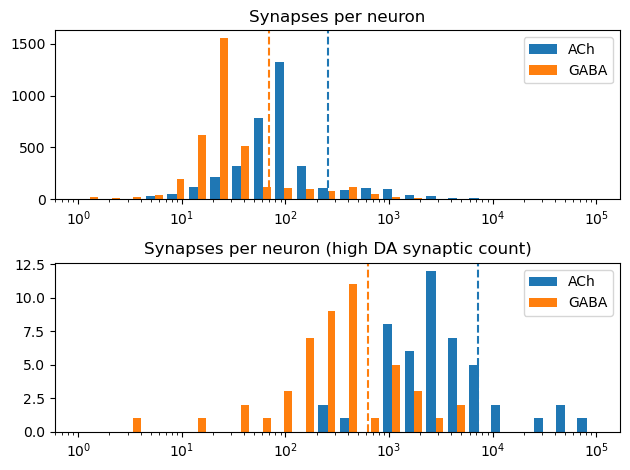

In [83]:
logbins = np.logspace(0, 5, 25)
plt.subplot(211)
plt.hist(
    [ach_synapses_per_neuron, 
    gaba_synapses_per_neuron],
    bins=logbins, label=("ACh", "GABA"))
plt.axvline(ach_synapses_per_neuron.mean(), ls="--", c="tab:blue")
plt.axvline(gaba_synapses_per_neuron.mean(), ls="--", c="tab:orange")
plt.xscale("log")
plt.title("Synapses per neuron")
plt.legend()

plt.subplot(212)
plt.hist(
    [ach_synapses_per_neuron[da_synapses_per_neuron > threshold], 
    gaba_synapses_per_neuron[da_synapses_per_neuron > threshold]],
    bins=logbins, label=("ACh", "GABA"))
plt.axvline(ach_synapses_per_neuron[da_synapses_per_neuron > threshold].mean(), ls="--", c="tab:blue")
plt.axvline(gaba_synapses_per_neuron[da_synapses_per_neuron > threshold].mean(), ls="--", c="tab:orange")
plt.xscale('log')
plt.title("Synapses per neuron (high DA synaptic count)")
plt.legend()

plt.tight_layout()
plt.show()